This notebook shows how to **optimize** the **parameters** of a **scalar field** so it matches another **scalar field**.

The idea is that we define both the **optimized** and **target scalar fields** using **SDFs** and **post-processing functions**, then we compute a **cost function** based on how **similar** the **two fields** are at **every point in space**. We **tune** the **parameters** and **repeat** until the **cost function converges** and hopefully, the **fields** are as **similar as possible**.

We use **SDFs** and **post-processing functions** because by using **automatic differentiation (*JAX*)** it is relatively easy to compute the **gradient** of the **scalar field** at **every point in space** with **respect** to its **parameters**. This enables us to use **gradient-based minimization/optimization algorithms** (*Gradient Descent, ADAM, etc.*) to tune the **parameters** of the **optimized field**. In this example we use an **optimizer** found in ***Optax***.

Essentially, this is a very basic example of ***shape optimization***.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from jax import jvp, jacfwd, value_and_grad, config
import jax.numpy as jnp
import optax

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.jax_cores.sdf_2D_jax import sdf_circle
from spomso.jax_cores.transformations_jax import compound_euclidian_transform_sdf
from spomso.jax_cores.modifications_jax import gaussian_falloff

from spomso.jax_cores.combine_jax import combine_2_sdfs, parametric_combine_2_sdfs
from spomso.jax_cores.combine_jax import union2, smooth_union2_3o


config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

# PARAMETERS

In [2]:
# size of the volume
co_size = 8, 8
# resolution of the volume
co_resolution = 400, 400

show = "FIELD"  # FIELD, TARGET, OBJECTIVE
show_midplane = True
show_3d = True

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a **numpy.ndarray** with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# SDF PARAMETERS

Both the **optimized/dynamic field** and the **target field** are defined using **SDFs**. 
To keep things simple both the **dynamic** and the **target field** have the same spatial dependance (**smoothed circle**), the only difference is in the **origin/position** of the fields. The **origin/position** of the fields will be the only **free parameter**.

Define the **radii** of the **circles**:

In [4]:
radius = 1., 1., 1.

Define the **initial positions** of the **circles**:

In [5]:
x = 0.0, 0.1, -1.
y = 0.0, 0.2, 0.5

Define the **target positions** of the **circles**:

In [6]:
x_target = 2.2, 0.4, -2.
y_target = -1.0, -0.2, 1.1

The **optimization** can also be done using **pure SDFs (circles)** - without any additional **post-processing** functions.

In [7]:
pure_sdf = False

The **circles** in the **dynamic field** can be **combined** using a **smooth union** function.

In [8]:
smooth_combine = False

# CREATE SDFs

Eventhough both the **dynamic** and **target fields** are (in this case) the same mathematically, we define them seperatly for the sake generality. 

Define a **target field** where the input is the **target position** of the **smoothed circle**:

In [9]:
def target_sdf(x0, y0):

    vec = jnp.asarray([x0[0], y0[0], 0])
    sdf = compound_euclidian_transform_sdf(sdf_circle, jnp.eye(3), vec, 1.)

    vect = jnp.asarray([x0[1], y0[1], 0])
    sdf_t = compound_euclidian_transform_sdf(sdf_circle, jnp.eye(3), vect, 1.)

    sdf = parametric_combine_2_sdfs(sdf, sdf_t, (radius[0],), (radius[1],), smooth_union2_3o, 0.75)

    if len(x0) > 2:
        for i in range(2, len(x0)):
            vect = jnp.asarray([x0[i], y0[i], 0])
            sdf_t = compound_euclidian_transform_sdf(sdf_circle, jnp.eye(3), vect, 1.)
            sdf = parametric_combine_2_sdfs(sdf, sdf_t, (), (radius[i],), smooth_union2_3o, 0.75)

    if not pure_sdf:
        sdf = gaussian_falloff(sdf, 1., 0.5)
    out = sdf(coor)

    return out

Define the **field** of a **circle** where the input is the **pointcloud of coordinates**, and the **position** and **radius** of the **circle**:

In [10]:
def s_circle(co, vec, r):
    co = jnp.subtract(co.T, vec).T + 0.001
    out = sdf_circle(co, r)
    return out

Define the **dynamic field** where the input are the **positions** of the **circles**:

In [11]:
def combined_dynamic_field(vecs):

    if smooth_combine:
        sdf = parametric_combine_2_sdfs(s_circle, s_circle,
                                        (vecs[:, 0], radius[0]), (vecs[:, 1], radius[1]),
                                        smooth_union2_3o, 0.75)
    else:
        sdf = combine_2_sdfs(s_circle, s_circle,
                                        (vecs[:, 0], radius[0]), (vecs[:, 1], radius[1]),
                                        union2)
    if vecs.shape[1] > 2:
        for i in range(2, vecs.shape[1]):
            if smooth_combine:
                sdf = parametric_combine_2_sdfs(sdf, s_circle,
                                                (), (vecs[:, i], radius[i]),
                                                smooth_union2_3o, 0.75)
            else:
                sdf = combine_2_sdfs(sdf, s_circle,
                                                (), (vecs[:, i], radius[i]),
                                                union2)

    if not pure_sdf:
        sdf = gaussian_falloff(sdf, 1., 0.5)
    out = sdf(coor)
    return out

Define the **objective/cost function**, where the inputs are the **smoothed circle field** and the **target field**:

In [12]:
def objective_function(f_, t_):
    m = (f_ - t_)**2
    return m

# PRECOMPUTE

Compute the **target field**:

In [13]:
target_pattern = target_sdf(x_target, y_target)

Define the **worker** for the **optax optimizer**. This function takes the **optimized parameters** as the *input* and *returns* the **value** of the **cost function**:

In [14]:
def worker(p):
    dynamic_pattern = combined_dynamic_field(p)
    out = objective_function(dynamic_pattern, target_pattern)
    out = jnp.sum(out)
    return out

## PLOT TARGET FIELD

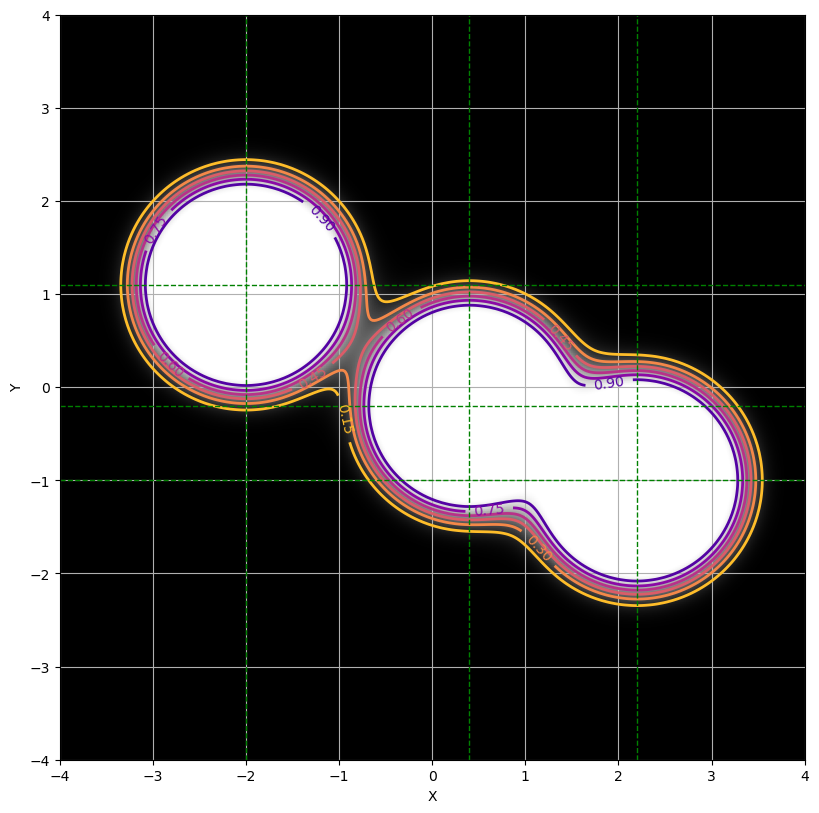

In [15]:
if show_midplane and (show=="TARGET" or show=="FIELD"):
    target_field = smarter_reshape(target_pattern, co_resolution)
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    ax.imshow(target_field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs1 = ax.contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    target_field[:, :],
                    cmap="plasma_r",
                    linewidths=2)
    ax.clabel(cs1, inline=True, fontsize=10)
    for i in range(len(x_target)):
        ax.axvline(x=x_target[i], color='green', linestyle='--', linewidth=1)
        ax.axhline(y=y_target[i], color='green', linestyle='--', linewidth=1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid()
    fig.tight_layout()
    plt.show()

# OPTIMIZATION PARAMETERS

Maximum number of **optimization iterations**:

In [16]:
max_iterations = 1000

The **optimizer** will **stop** when the **relative tolerance** of the **cost function** is **less** than this number:

In [17]:
relative_cost_difference = 1e-6

The **optimizer** will **stop** when the **cost function** is **less** than this number:

In [18]:
stop_cost_value = 1e-6

Start **learning rate** of the **optimizer**:

In [19]:
start_learning_rate = 0.01

# FIND SOLUTION

**Initialize parameters** of the **model** and **optimizer**:

In [20]:
params = jnp.array([x, y, jnp.zeros(len(x))])
optimizer = optax.adam(start_learning_rate)
opt_state = optimizer.init(params)

**Optimization/update loop:**

In [21]:
prev_value = 1e16
best_value, best_params = 1e16, params.copy()
for i in range(max_iterations):
    value, grads = value_and_grad(worker)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    print(f"Iteration: {i + 1}", "Value:", value, "Parameters:", params, "Gradient:", grads)

    if value < stop_cost_value:
        break

    rtol = jnp.abs(value / prev_value - 1)
    if rtol < relative_cost_difference:
        break
    else:
        prev_value = value.copy()
        print("Relative tolerance:", rtol)

    if value < best_value:
        best_value, best_params = value, params.copy()

    params = optax.apply_updates(params, updates)

Iteration: 1 Value: 20249.37081471386 Parameters: [[ 0.   0.1 -1. ]
 [ 0.   0.2  0.5]
 [ 0.   0.   0. ]] Gradient: [[-2708.2796538  -1373.66905597  4155.82615231]
 [ 2062.3829321   3212.71738664 -3540.31030437]
 [    0.             0.             0.        ]]
Relative tolerance: 0.9999999999979751
Iteration: 2 Value: 20078.77935961527 Parameters: [[ 0.01  0.11 -1.01]
 [-0.01  0.19  0.51]
 [ 0.    0.    0.  ]] Gradient: [[-2734.35478712 -1396.40085953  4253.62793692]
 [ 1989.28498147  3194.73172842 -3494.03186523]
 [    0.             0.             0.        ]]
Relative tolerance: 0.008424531145166947
Iteration: 3 Value: 19908.065747804445 Parameters: [[ 0.02000238  0.12000394 -1.02000539]
 [-0.01998897  0.1800015   0.51999635]
 [ 0.          0.          0.        ]] Gradient: [[-2781.43187355 -1400.74959276  4349.77765637]
 [ 1922.03983973  3168.12066646 -3449.13534009]
 [    0.             0.             0.        ]]
Relative tolerance: 0.00850219073347569
Iteration: 4 Value: 19737.2

## Final results:

In [22]:
value, grads = value_and_grad(worker)(params)
if value > best_value:
    value, params = best_value, best_params.copy()

print("\nFinal results:", "\nValue:", value, "\nParameters:", params, "\nGradient:", grads, "\n")


Final results: 
Value: 62.14545443577609 
Parameters: [[ 0.40315982  2.187884   -1.99211828]
 [-0.1992783  -0.99317359  1.09726708]
 [ 0.          0.          0.        ]] 
Gradient: [[-2.98151649  1.45840923 -0.39263995]
 [ 0.2437803   2.21925954 -0.03880861]
 [ 0.          0.          0.        ]] 



# EVALUATE SOLUTION

In [23]:
x_solution, y_solution, z_solution = tuple(params)

if show == "OBJECTIVE":
    def shown_field(x_, y_):
        v = jnp.asarray([x_, y_, jnp.zeros(len(x_))])
        return objective_function(combined_dynamic_field(v), target_sdf(x_target, y_target))
else:
    def shown_field(x_, y_):
        v = jnp.asarray([x_, y_, jnp.zeros(len(x_))])
        return combined_dynamic_field(v)

Evaluate the **SDF** of the **geometry** to create a signed distance field 2D map.

In [24]:
final_pattern = shown_field(x_solution, y_solution)

Calculate the **Jacobian** with respect to the **x-position** (argnums=0), or **y-position** (argnums=1) of the **first point** (point_index = 0):

In [25]:
point_index = 0
gradient_pattern = jacfwd(shown_field, argnums=0)(x_solution, y_solution)[:, point_index]

Note thst the **first point** in the **solution does not** necessarily **represent** the **first target point**.

Convert the **final pattern** and the **gradient pattern** into 2D images:

In [26]:
field = smarter_reshape(final_pattern, co_resolution)
gradient_field = smarter_reshape(gradient_pattern, co_resolution)

# PLOT

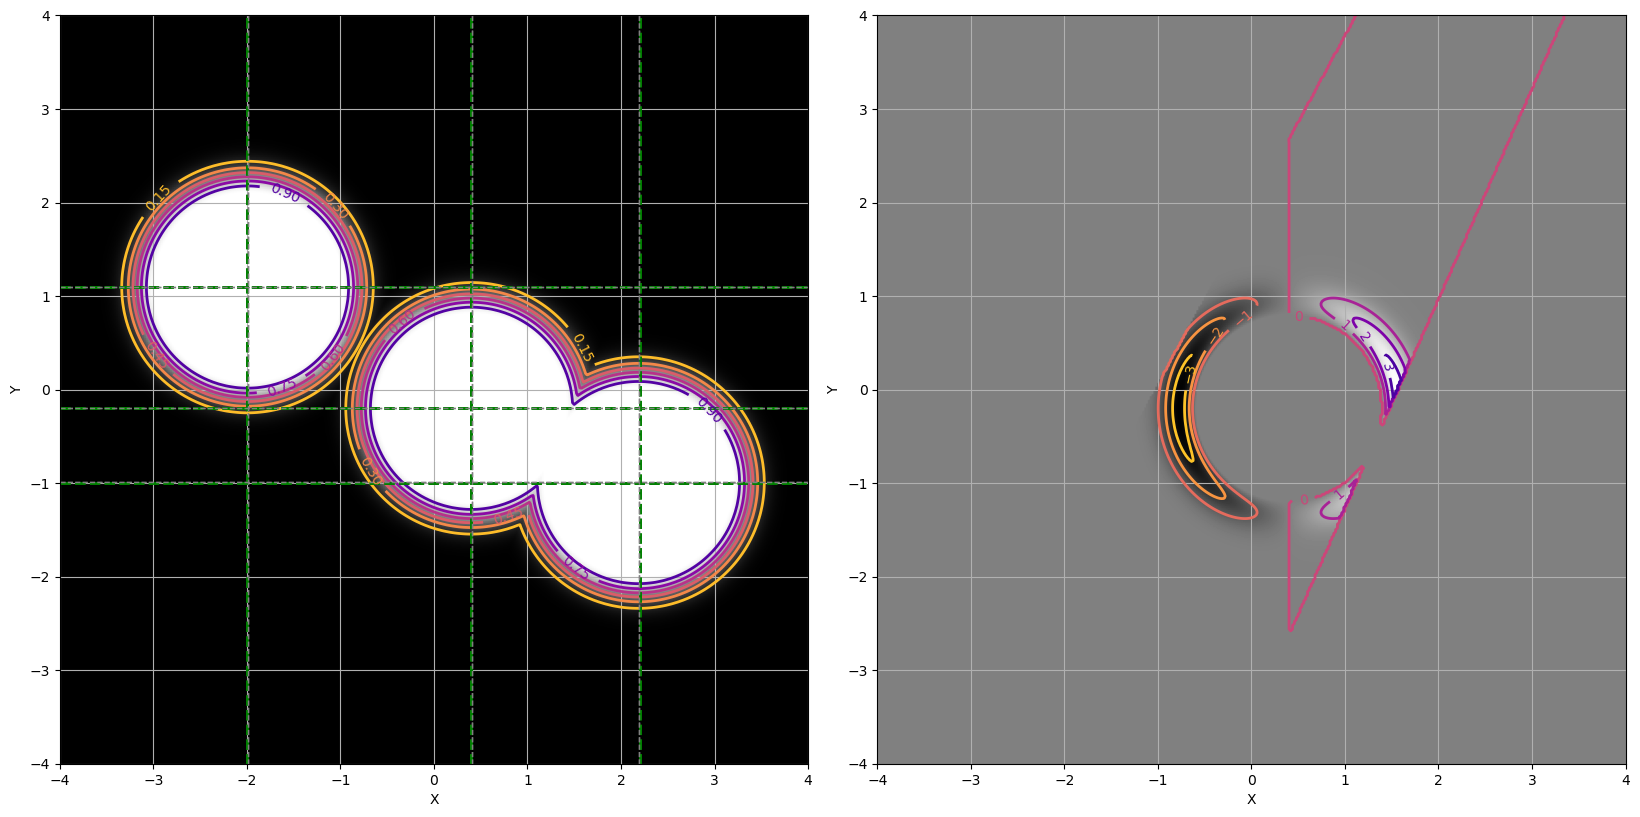

In [27]:
if show_midplane:
    fig, axs = plt.subplots(1, 2, figsize=(2*8.25, 8.25))

    # FIELD
    axs[0].imshow(field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs1 = axs[0].contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :],
                    cmap="plasma_r",
                    linewidths=2)
    axs[0].clabel(cs1, inline=True, fontsize=10)
    axs[0].grid()
    for i in range(len(x_target)):
        axs[0].axvline(x=x_target[i], color='green', linestyle='--', linewidth=2)
        axs[0].axhline(y=y_target[i], color='green', linestyle='--', linewidth=2)
    for i in range(len(x_solution)):
        axs[0].axvline(x=x_solution[i], color='grey', linestyle='--', linewidth=1)
        axs[0].axhline(y=y_solution[i], color='grey', linestyle='--', linewidth=1)

    # GRADIENT
    axs[1].imshow(gradient_field[:, :].T,
                  cmap="binary_r",
                  extent=(-co_size[0] / 2, co_size[0] / 2,
                          -co_size[1] / 2, co_size[1] / 2),
                  origin="lower"
                  )
    cs2 = axs[1].contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                        coor[1].reshape(co_res_new[0], co_res_new[1]),
                        gradient_field[:, :],
                        cmap="plasma_r",
                        linewidths=2)
    axs[1].clabel(cs2, inline=True, fontsize=10)
    axs[1].grid()
    for i in range(len(x_target)):
        axs[0].axvline(x=x_target[i], color='green', linestyle='--', linewidth=2)
        axs[0].axhline(y=y_target[i], color='green', linestyle='--', linewidth=2)
    for i in range(len(x_solution)):
        axs[0].axvline(x=x_solution[i], color='grey', linestyle='--', linewidth=1)
        axs[0].axhline(y=y_solution[i], color='grey', linestyle='--', linewidth=1)

    for ax in axs:
        ax.set_xlabel("X")
        ax.set_ylabel("Y")

    fig.tight_layout()
    plt.show()

In [ ]:
if show_3d:
    patterns = ((field, gradient_field),)
    titles = ("Field", "Gradient")

    fig = make_subplots(rows=1, cols=2,
                        specs=[[{'is_3d': True}, {'is_3d': True}]],
                        subplot_titles=titles
                        )

    for i in range(1):
        for j in range(2):
            fig.add_trace(go.Surface(x=coor[0].reshape(co_res_new[0], co_res_new[1]),
                                     y=coor[1].reshape(co_res_new[0], co_res_new[1]),
                                     z=patterns[i][j][:, :],
                                     contours={
                                         "z": {"show": True,
                                               "start": np.floor(np.amin(patterns[i][j][:, :]*10))/10,
                                               "end": np.ceil(np.amax(patterns[i][j][:, :]*10))/10,
                                               "size": 0.1}
                                     },
                                     cmin=0,
                                     cmax=1),
                          1 + i, 1 + j,
                          )

            fig.update_traces(contours_z=dict(show=True, usecolormap=False,
                                              highlightcolor="limegreen", project_z=True))

    fig.show()
